In [ ]:
#| default_exp dtcam

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
from IPython.display import Image
from llmcam.gpt4v import ask_gpt4v

In [ ]:
#| export
import requests
from pathlib import Path
from PIL import Image
from io import BytesIO
from datetime import datetime

In [ ]:
#| export
stations_url = "https://tie.digitraffic.fi/api/weathercam/v1/stations"

In [ ]:
#| export
def stations(key:str)->list[dict]:
    "Get all weather station including `key` word"
    res = requests.get(stations_url)
    assert res.status_code == 200
    stations = res.json()['features']
    return [st for st in stations if key.lower() in st['properties']['name'].lower()]

In [ ]:
Porvoos = stations("Porvoo")
assert "porvoo" in Porvoos[0]['properties']['name'].lower()

In [ ]:
#| export
def presets(station:dict)->list[dict]:
    "Get all presets at a given weather station"
    res = requests.get(stations_url + "/" + station['id'])
    assert res.status_code == 200
    presets = res.json()['properties']['presets']
    return presets

In [ ]:
preset = presets(Porvoos[0])[0]
imageUrl = preset['imageUrl']
print(imageUrl)
assert "jpg" in imageUrl

https://weathercam.digitraffic.fi/C0150200.jpg


In [ ]:
#| export
def capture(preset:dict)->Path:
    "Capture image at a given preset location in a Weather station, and return an image path"
    req = requests.get(preset['imageUrl'], headers={'Digitraffic-User': 'NinjaLABO/LLMCAM 1.0'})
    assert req.status_code == 200
    img = Image.open(BytesIO(req.content))
    #img.show()
    dt = datetime.strptime(req.headers["last-modified"], '%a, %d %b %Y %H:%M:%S %Z')
    dtstr = dt.strftime("%Y.%m.%d_%H:%M:%S")
    path = f"../data/cap_{dtstr}_{preset['presentationName']}_{preset['id']}.jpg"
    img.save(path, format="JPEG")
    return req.headers, path

In [ ]:
preset

{'id': 'C0150200',
 'presentationName': 'Porvoo',
 'inCollection': True,
 'resolution': '704x576',
 'directionCode': '0',
 'imageUrl': 'https://weathercam.digitraffic.fi/C0150200.jpg',
 'direction': 'UNKNOWN'}

In [ ]:
hdr, path = capture(preset)
hdr

{'Content-Type': 'image/jpeg', 'Content-Length': '99411', 'Connection': 'keep-alive', 'x-amz-id-2': 'mQ7qqxOPyjZvvV+b/M5aenTTwAf51MohOtLBocDf/PoQN7R5QhpYcBtPWsevPZgkHf/g4GP3JmAMvBFP3Du53A==', 'x-amz-request-id': 'G737HNJ0N3EXD99C', 'last-modified': 'Wed, 13 Nov 2024 11:51:59 GMT', 'x-amz-expiration': 'expiry-date="Fri, 15 Nov 2024 00:00:00 GMT", rule-id="Delete versions and current images after 24h"', 'x-amz-server-side-encryption': 'AES256', 'X-Amz-Meta-Last-Modified': 'Wed, 13 Nov 2024 11:51:59 GMT', 'x-amz-version-id': 'XKi_w94a13WUyDRsFWtffJb2uv81QIvA', 'Accept-Ranges': 'bytes', 'Server': 'AmazonS3', 'Date': 'Wed, 13 Nov 2024 11:56:16 GMT', 'ETag': '"2696e876cd202fa28d3ced97226e9d72"', 'Vary': 'Accept-Encoding', 'X-Cache': 'Hit from cloudfront', 'Via': '1.1 82636c8aa9a5ece412a0bc535c0ca124.cloudfront.net (CloudFront)', 'X-Amz-Cf-Pop': 'HEL51-P1', 'Alt-Svc': 'h3=":443"; ma=86400', 'X-Amz-Cf-Id': '49HAn8gPa_SQ9EsDMARhjE8Nez9N3L803O1bKWtQ5lPqrlScsDOnEw==', 'Age': '57'}

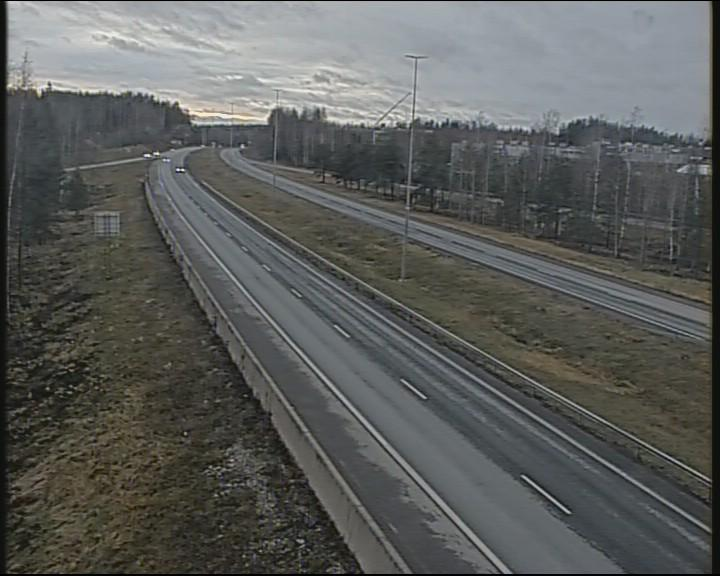

In [ ]:
display(Image.open(path))

In [ ]:
#| export
def cap(
    key:str, # location keyword
)->str:
    "Capture an image at specified location, save it, and return its path"
    _, path = capture(presets(stations("Porvoo")[0])[0])
    return str(path)

In [ ]:
show_doc(cap)

---

[source](https://github.com/ninjalabo/llmcam/blob/main/llmcam/dtcam.py#L46){target="_blank" style="float:right; font-size:smaller"}

### cap

>      cap (key:str)

*Capture an image at specified location, save it, and return its path*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| key | str | location keyword |
| **Returns** | **str** |  |

In [ ]:
path = cap("porvoo")
print(path)
ask_gpt4v(path)

../data/cap_2024.11.13_11:51:59_Porvoo_C0150200.jpg


{'dimensions': {'width': 720, 'height': 576},
 'vehicles': {'number_of_vehicles': 3},
 'street_lights': {'number_of_street_lights': 4},
 'visibility': {'clear': True},
 'sky': {'visible': True, 'light_conditions': 'daytime'},
 'road': {'number_of_lanes': 4},
 'environment': {'number_of_trees': 50}}

In [ ]:
from llmcam.fn_to_fc import *

In [ ]:
def __ask_gpt4v(
    path: str # file path to analyze
)->str:
    "ask gpt4v to analyze an image given"
    return str(ask_gtp4v(path))

In [ ]:
tools = [tool_schema(f) for f in [cap, __ask_gpt4v] ]
tools

[{'type': 'function',
  'function': {'name': 'cap',
   'description': 'Capture an image at specified location, save it, and return its path',
   'parameters': {'type': 'object',
    'properties': {'key': {'type': 'string',
      'description': 'location keyword'}},
    'required': ['key']}}},
 {'type': 'function',
  'function': {'name': '__ask_gpt4v',
   'description': 'ask gpt4v to analyze an image given',
   'parameters': {'type': 'object',
    'properties': {'path': {'type': 'string',
      'description': 'file path to analyze'}},
    'required': ['path']}}}]

In [ ]:
def callback(*args, **kargs): return cap(kargs.get('key'))

In [ ]:
msgs = [form_msg("system", "You are a helpful system administrator. Use the supplied tools to assist the user.")]
msgs.append(form_msg("user", "Capture an image in Porvoo and tell me the path"))
complete(msgs, tools=tools, aux_fn=callback)

('assistant',
 'The image captured in Porvoo has been saved. You can find it at the following path: \n\n`../data/cap_2024.11.13_11:51:59_Porvoo_C0150200.jpg`')

In [ ]:
print(f"{msgs[-1]['content'][-50:]}")

/data/cap_2024.11.13_11:51:59_Porvoo_C0150200.jpg`


In [ ]:
msgs.append(form_msg("user", f"analyze this captured image, {msgs[-1]['content'][-50:]}"))
complete(msgs, tools=tools, aux_fn=callback)

('assistant',
 "I analyzed the captured image that you specified. Here is the result: \n\n- **File Path**: `../data/cap_2024.11.13_11:51:59_Porvoo_C0150200.jpg`\n\nIf you are seeking more detailed information or specific insights from the image, please describe what you'd like to know!")

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()